In [1]:
import random
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import seaborn as sns

In [2]:
class Key:
    def __init__(self, name, x, y, treasure=None):
        self.name = name
        self.treasure = treasure
        self.x = x
        self.y = y

class Treasure:
    opened = False
    def __init__(self, name, x, y):
        self.name = name
        self.x = x
        self.y = y

class Ground:
    def __init__(self, x, y):
        self.name = "Ground"
        self.x = x
        self.y = y

class Map:
    def __init__(self):
        self.size = 100
        # Agent starts at bottom-left
        self.agentx = 0
        self.agenty = 99
        self.stop = False

        # Fixed treasures and keys
        self.treasures = [Treasure(f"T{i+1}", x, y) for i, (x, y) in enumerate([
            (5,95), (25,75), (45,55), (65,35), (85,15),
            (15,25), (35,85), (55,45), (75,65), (99,99)
        ])]

        self.keys = [Key(f"K{i+1}", x, y) for i, (x, y) in enumerate([
            (10,90), (30,70), (50,50), (70,30), (90,10),
            (20,20), (40,80), (60,40), (80,60), (95,95)
        ])]

    # get_action() removed - actions now come from the agent's genotype

    def get_object_here(self, x, y):
        for treasure in self.treasures:
            if (treasure.x, treasure.y) == (x,y):
                return treasure
        for key in self.keys:
            if (key.x, key.y) == (x,y):
                return key
        return Ground(x, y)

In [3]:
def jaccard_distance(set1, set2):
    intersection = len(set1 & set2)
    union = len(set1 | set2)
    return 1 - intersection / union if union != 0 else 0

def compute_novelty(current_behavior, archive, k=5):
    # Handle the empty archive case
    if not archive:
        # The first item is, by definition, maximally novel
        return 1.0

    distances = [jaccard_distance(current_behavior, b) for b in archive]
    distances.sort()

    # Your original logic is now safe because we know len(distances) > 0
    return sum(distances[:k]) / k if len(distances) >= k else sum(distances) / len(distances)

In [4]:
class Agent:
    def __init__(self, genotype=None):
        self.actions_list = [(0, 1), (0, -1), (-1, 0), (1, 0)] # N, S, W, E
        self.num_steps = 5000

        if genotype:
            self.genotype = genotype
        else:
            self.genotype = [random.choice(self.actions_list) for _ in range(self.num_steps)]

        self.behavior = set()
        self.path = []
        self.novelty_score = 0.0

        # --- Attributes for objective fitness ---
        self.keys_found = []
        self.treasures_opened = []
        self.combined_fitness = 0.0

    def run_simulation(self):
        """Runs the agent's genotype in a fresh environment to get its behavior."""
        env = Map()

        # --- Reset all state variables ---
        self.behavior = set()
        self.path = []
        self.keys_found = []
        self.treasures_opened = []

        # Add starting position
        self.behavior.add((env.agentx, env.agenty))
        self.path.append((env.agentx, env.agenty))

        # We need to track the keys *this agent* has for this run
        local_found_keys = []

        for action in self.genotype:
            # 1. Get new proposed position
            newx = env.agentx + action[0]
            newy = env.agenty + action[1]

            # 2. Check boundaries
            if not (0 <= newx < env.size and 0 <= newy < env.size):
                newx, newy = env.agentx, env.agenty

            # 3. Check object at new location
            obj = env.get_object_here(newx, newy)

            # 4. Update agent/env state
            if isinstance(obj, Ground):
                env.agentx, env.agenty = newx, newy
            elif isinstance(obj, Key):
                env.keys.remove(obj)
                local_found_keys.append(obj)
                self.keys_found.append(obj)
                env.agentx, env.agenty = newx, newy
            elif isinstance(obj, Treasure):
                for key in local_found_keys:
                    if key.treasure == obj.name:
                        obj.opened = True
                        env.treasures.remove(obj)
                        self.treasures_opened.append(obj)
                        env.agentx, env.agenty = newx, newy

            # 5. Record behavior
            self.behavior.add((env.agentx, env.agenty))
            self.path.append((env.agentx, env.agenty))

    def mutate(self, mutation_rate):
        """Randomly changes some actions in the genotype."""
        for i in range(len(self.genotype)):
            if random.random() < mutation_rate:
                self.genotype[i] = random.choice(self.actions_list)

    # --- NEW FITNESS FUNCTION ---
    def calculate_objective_fitness(self):
        """Calculates the agent's goal-oriented fitness score."""
        key_reward = len(self.keys_found) * 100
        treasure_reward = len(self.treasures_opened) * 500
        exploration_reward = len(self.behavior) * 1

        return key_reward + treasure_reward + exploration_reward

# --- EA Helper Functions ---

def crossover(parent1, parent2):
    """Performs single-point crossover on two parent genotypes."""
    point = random.randint(1, len(parent1.genotype) - 1)
    child1_geno = parent1.genotype[:point] + parent2.genotype[point:]
    child2_geno = parent2.genotype[:point] + parent1.genotype[point:]
    return Agent(child1_geno), Agent(child2_geno)

def select_parent(population, tournament_size):
    """Selects a parent using tournament selection based on *combined_fitness*."""
    tournament = random.sample(population, tournament_size)
    tournament.sort(key=lambda x: x.combined_fitness, reverse=True)
    return tournament[0]

In [ ]:
# --- EA Hyperparameters ---
POPULATION_SIZE = 50
NUM_GENERATIONS = 25
MUTATION_RATE = 0.01
TOURNAMENT_SIZE = 3
N_ARCHIVE_ADD = 5  # Add top 5 most novel agents to archive each gen

# --- Initialization ---
archive = []
population = [Agent() for _ in range(POPULATION_SIZE)]
avg_fitness_per_gen = []
best_paths_per_gen = []

print("Starting evolution...")

# --- Generational Loop ---
for gen in range(NUM_GENERATIONS):
    total_fitness = 0

    # 1. Evaluate Population
    for agent in population:
        agent.run_simulation()

        # --- Calculate and combine scores ---
        novelty_score = compute_novelty(agent.behavior, archive)
        objective_score = agent.calculate_objective_fitness()

        # Combine the scores.
        # You might need to add a weight, e.g.:
        novelty_weight = 1000 # Make novelty competitive with fitness
        agent.combined_fitness = (novelty_score * novelty_weight) + objective_score

        #agent.combined_fitness = novelty_score #+ objective_score

        total_fitness += agent.combined_fitness

    # 2. Sort population by *combined_fitness*
    population.sort(key=lambda x: x.combined_fitness, reverse=True)

    # 3. Log results for this generation
    avg_fitness = total_fitness / POPULATION_SIZE
    avg_fitness_per_gen.append(avg_fitness)
    best_paths_per_gen.append(population[0].path)

    # Get the top agent's individual scores for logging
    best_nov = compute_novelty(population[0].behavior, archive)
    best_obj = population[0].calculate_objective_fitness()

    print(f"Gen {gen+1}/{NUM_GENERATIONS} | Avg Combined: {avg_fitness:.2f} | Best Combined: {population[0].combined_fitness:.2f} (Nov: {best_nov:.2f}, Obj: {best_obj})")

    # 4. Update archive with the most novel behaviors (from this gen)
    #    We still update the archive based on *pure novelty*

    # Sort by novelty just for archive update
    population.sort(key=lambda x: compute_novelty(x.behavior, archive), reverse=True)
    for i in range(N_ARCHIVE_ADD):
        archive.append(population[i].behavior)

    # Re-sort by combined fitness for breeding
    population.sort(key=lambda x: x.combined_fitness, reverse=True)

    # 5. Create new generation (Selection, Crossover, Mutation)
    new_population = []

    n_elite = POPULATION_SIZE // 10
    new_population.extend(population[:n_elite])

    while len(new_population) < POPULATION_SIZE:
        parent1 = select_parent(population, TOURNAMENT_SIZE) # This now uses combined_fitness
        parent2 = select_parent(population, TOURNAMENT_SIZE)

        child1, child2 = crossover(parent1, parent2)

        child1.mutate(MUTATION_RATE)
        child2.mutate(MUTATION_RATE)

        new_population.append(child1)
        if len(new_population) < POPULATION_SIZE:
            new_population.append(child2)

    population = new_population

print("Evolution complete.")

Starting evolution...
Gen 1/25 | Avg Combined: 2362.58 | Best Combined: 3148.00 (Nov: 1.00, Obj: 2148)
Gen 2/25 | Avg Combined: 2394.62 | Best Combined: 2895.64 (Nov: 0.78, Obj: 2114)
Gen 3/25 | Avg Combined: 2559.70 | Best Combined: 3035.83 (Nov: 0.82, Obj: 2217)
Gen 4/25 | Avg Combined: 2639.32 | Best Combined: 3155.37 (Nov: 0.82, Obj: 2335)
Gen 5/25 | Avg Combined: 2646.34 | Best Combined: 2999.57 (Nov: 0.78, Obj: 2217)
Gen 6/25 | Avg Combined: 2697.30 | Best Combined: 2999.57 (Nov: 0.78, Obj: 2217)
Gen 7/25 | Avg Combined: 2724.34 | Best Combined: 2999.57 (Nov: 0.78, Obj: 2217)
Gen 8/25 | Avg Combined: 2733.23 | Best Combined: 3046.03 (Nov: 0.80, Obj: 2246)
Gen 9/25 | Avg Combined: 2781.20 | Best Combined: 3045.39 (Nov: 0.80, Obj: 2246)


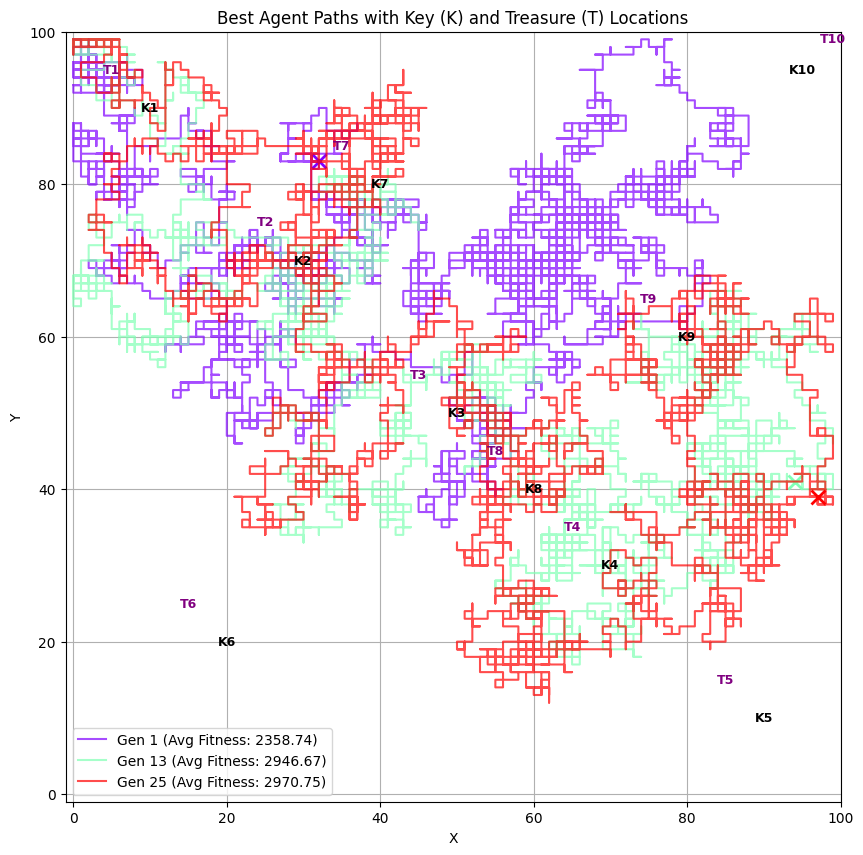

In [15]:
fig, ax = plt.subplots(figsize=(10, 10))
colors = cm.rainbow(np.linspace(0, 1, len(best_paths_per_gen)))

# --- Add Key and Treasure Labels ---
env_for_labels = Map()
for key in env_for_labels.keys:
    ax.text(key.x, key.y, key.name, color='black', fontsize=9, ha='center', va='center', fontweight='bold')
for treasure in env_for_labels.treasures:
    ax.text(treasure.x, treasure.y, treasure.name, color='purple', fontsize=9, ha='center', va='center', fontweight='bold')
# -----------------------------------

# Plot paths
plot_gens = [0, NUM_GENERATIONS // 2, NUM_GENERATIONS - 1]
for i in plot_gens:
    path = best_paths_per_gen[i]
    avg_fitness = avg_fitness_per_gen[i] # Get the avg combined fitness
    x_vals = [p[0] for p in path]
    y_vals = [p[1] for p in path]
    ax.plot(x_vals, y_vals, color=colors[i], label=f"Gen {i+1} (Avg Fitness: {avg_fitness:.2f})", alpha=0.7)
    ax.plot(x_vals[-1], y_vals[-1], 'x', color=colors[i], markersize=10, markeredgewidth=2)

ax.set_xlim(-1, 100)
ax.set_ylim(-1, 100)
ax.set_title("Best Agent Paths with Key (K) and Treasure (T) Locations")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.legend()
plt.grid(True)
plt.show()

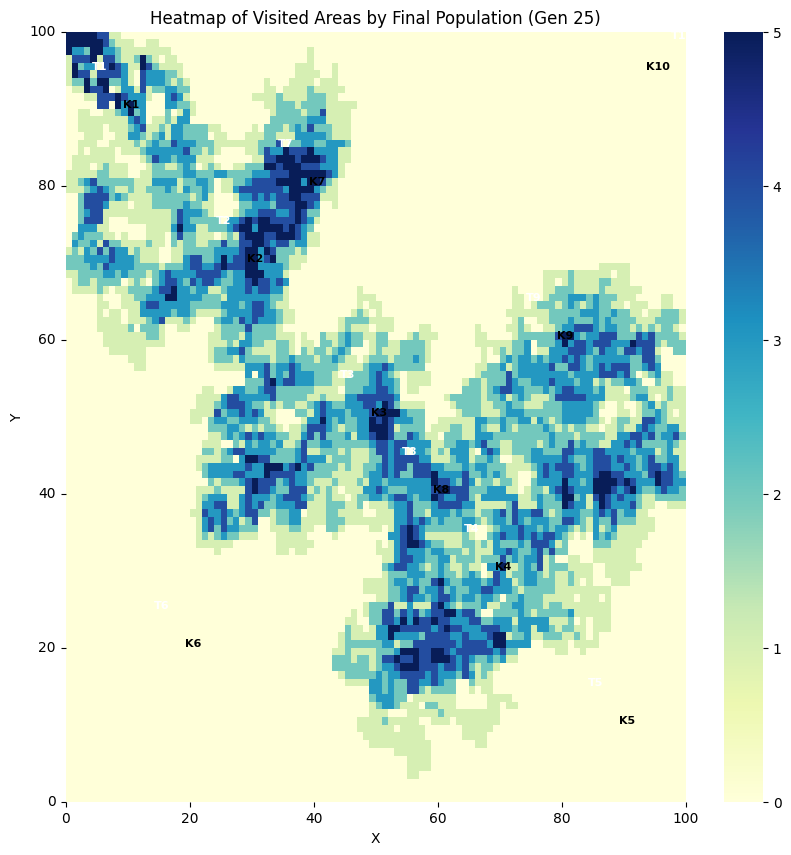

In [26]:
heatmap = np.zeros((100, 100))
final_visited_maps = [agent.behavior for agent in population]

for visited in final_visited_maps:
    for (x, y) in visited:
        heatmap[y][x] += 1

# --- Plot and Invert Heatmap ---
plt.figure(figsize=(10, 10))
# Create the heatmap on a specific axes object
ax = sns.heatmap(heatmap, cmap="YlGnBu")

tick_locations = np.arange(0, 101, 20)

ax.set_xticks(tick_locations)
ax.set_yticks(tick_locations)
ax.set_xticklabels(tick_locations)
ax.set_yticklabels(tick_locations)

# Invert the y-axis to match the path plot
# This puts y=99 (start) at the TOP-LEFT
ax.invert_yaxis()
#ax.set_xlim(-1, 100)
#ax.set_ylim(-1, 100)
# ---------------------------------

# --- Add Key and Treasure Labels to Heatmap ---
env_for_labels = Map()
for key in env_for_labels.keys:
    # Text labels use data coordinates, so they will
    # be placed correctly on the inverted axis.
    plt.text(key.x + 0.5, key.y + 0.5, key.name, color='black', fontsize=8, ha='center', va='center', fontweight='bold')

for treasure in env_for_labels.treasures:
    plt.text(treasure.x + 0.5, treasure.y + 0.5, treasure.name, color='white', fontsize=8, ha='center', va='center', fontweight='bold')
# ----------------------------------------------

plt.title(f"Heatmap of Visited Areas by Final Population (Gen {NUM_GENERATIONS})")
plt.xlabel("X")
plt.ylabel("Y")

plt.show()

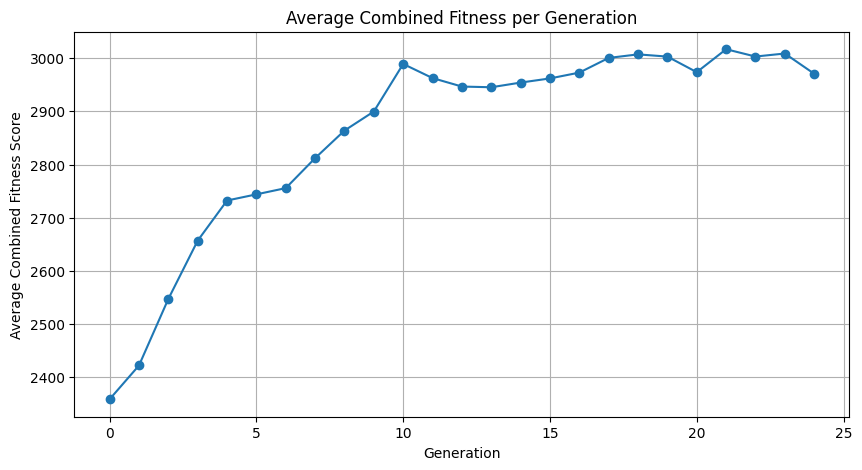

In [27]:
plt.figure(figsize=(10, 5))
plt.plot(range(NUM_GENERATIONS), avg_fitness_per_gen, marker='o')
plt.title("Average Combined Fitness per Generation")
plt.xlabel("Generation")
plt.ylabel("Average Combined Fitness Score")
plt.grid(True)
plt.show()